# Evaluación Causal del Efecto de la Tasa de Alimentación en la Sostenibilidad de un Sistema RAS de Acuicultura

## Contexto:
En un sistema RAS (Recirculating Aquaculture System) para el cultivo de peces, la tasa de alimentación es una variable crítica. Una alimentación adecuada promueve un crecimiento óptimo, pero una sobrealimentación puede deteriorar la calidad del agua, aumentar los costos y afectar negativamente la sostenibilidad.
Para fundamentar decisiones de gestión, es útil determinar el efecto causal de la tasa de alimentación sobre un índice de sostenibilidad (que podría incluir indicadores de crecimiento, calidad del agua y eficiencia económica), controlando por factores ambientales como temperatura, oxígeno y pH.

## Enfoque:
Se simularán datos con variables:

- Ambientales: Temperatura, Oxígeno, pH.
- Operativas: Tasa de Alimentación (tratamiento) y Densidad de Población.
- Resultado: Índice de Sostenibilidad (un valor continuo).

Posteriormente, se definirá un DAG que refleja nuestras suposiciones causales y se utilizará DoWhy para estimar el efecto causal de la tasa de alimentación en la sostenibilidad.

## Estructura del Notebook
1. Importación de librerías y configuración inicial.
2. Simulación y generación del dataset sintético.
3. Definición del DAG causal.
4. Creación y estimación del modelo causal con DoWhy.
5. Realización de la inferencia (estimación del efecto causal) y análisis de resultados.
6. Conclusiones y aplicaciones en la gestión de la sostenibilidad en acuicultura RAS.

Ejemplo para desarrollar un modelo causal que ayude a comprender y fundamentar políticas de sostenibilidad en un sistema RAS de acuicultura, utilizando un enfoque de análisis causal con la librería DoWhy. En este caso paradigmático, se simularán datos donde la variable de interés (por ejemplo, un índice de sostenibilidad) se ve afectada por factores operativos y ambientales, y queremos estimar el efecto causal de la tasa de alimentación en la sostenibilidad, controlando por otras variables.

## 1. Importación de Librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings

# Librerías de pgmpy para redes bayesianas
from pgmpy.estimators import HillClimbSearch, BIC, K2, BDeu, MaximumLikelihoodEstimator
from pgmpy.models import DiscreteBayesianNetwork as BayesianNetwork  # Actualizado: BayesianModel está deprecado
from pgmpy.inference import VariableElimination

# Librerías para validación
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report)
from collections import Counter

# Suprimir warnings de deprecación
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")
print("Librerías cargadas correctamente.")

## 2. Generación del Dataset Sintético
Simulamos un conjunto de datos donde:

- Temperatura, Oxígeno y pH son exógenos (variables ambientales).
- Tasa_Alimentacion depende de algunas variables ambientales.
- Densidad se asume independiente.
- Sostenibilidad depende de la Tasa_Alimentacion (efecto deseado) y de la Densidad (como factor de control).

In [19]:
np.random.seed(42)
num_samples = 500

# Variables ambientales
temperatura = np.random.normal(loc=22, scale=2, size=num_samples)  # °C
salinidad = np.random.normal(loc=35, scale=1, size=num_samples)      # ppt
ph = np.random.normal(loc=7.5, scale=0.3, size=num_samples)

# Variables operativas
consumo_combustible = np.random.normal(loc=200, scale=30, size=num_samples)  # litros/hora
flota = np.random.randint(low=50, high=150, size=num_samples)                 # número de buques

# Variables económicas
precio_mercado = np.random.normal(loc=500, scale=50, size=num_samples)        # USD/tonelada
mantenimiento = np.random.normal(loc=100000, scale=15000, size=num_samples)    # USD

# Variable de sostenibilidad (0 = insostenible, 1 = sostenible)
sostenibilidad = ((temperatura > 18) & (temperatura < 24) &
                  (salinidad > 34) & (salinidad < 36) &
                  (consumo_combustible < 220) &
                  (precio_mercado > 450)).astype(int)

df = pd.DataFrame({
    'Temperatura': temperatura,
    'Salinidad': salinidad,
    'pH': ph,
    'Consumo_Combustible': consumo_combustible,
    'Flota': flota,
    'Precio_Mercado': precio_mercado,
    'Mantenimiento': mantenimiento,
    'Sostenibilidad': sostenibilidad
})

print("Datos continuos:")
print(df.head())


Datos continuos:
   Temperatura  Salinidad        pH  Consumo_Combustible  Flota  \
0    22.993428  35.926178  7.919807           223.350832     79   
1    21.723471  36.909417  7.777390           183.464429    144   
2    23.295377  33.601432  7.517889           175.454033    124   
3    25.046060  35.562969  7.305919           199.898766    148   
4    21.531693  34.349357  7.709467           194.894461    121   

   Precio_Mercado  Mantenimiento  Sostenibilidad  
0      445.727196  102361.718874               0  
1      535.421052   92704.646597               0  
2      584.177325  124125.839670               0  
3      473.643931  105324.523821               0  
4      403.327945   94674.270334               0  


## 3. Definición del DAG Causal
Definimos el DAG basado en nuestras suposiciones. Por ejemplo, asumimos que:

- Las variables ambientales (Temperatura, Oxígeno, pH) afectan la Tasa_Alimentacion.
- La Tasa_Alimentacion y la Densidad afectan la Sostenibilidad.
- Representamos esto en un formato de grafo en lenguaje DOT.

In [20]:
# Discretizar Temperatura
def discretizar_temperatura(t):
    if t < 20:
        return 'Baja'
    elif t < 24:
        return 'Media'
    else:
        return 'Alta'

df['Temperatura_disc'] = df['Temperatura'].apply(discretizar_temperatura)

# Discretizar Salinidad
def discretizar_salinidad(s):
    if s < 34:
        return 'Baja'
    elif s < 36:
        return 'Media'
    else:
        return 'Alta'

df['Salinidad_disc'] = df['Salinidad'].apply(discretizar_salinidad)

# Discretizar pH
def discretizar_ph(p):
    if p < 7.3:
        return 'Bajo'
    elif p < 7.7:
        return 'Medio'
    else:
        return 'Alto'

df['pH_disc'] = df['pH'].apply(discretizar_ph)

# Discretizar Consumo de Combustible (proxy de Tasa de Alimentación)
def discretizar_consumo(c):
    if c < 180:
        return 'Bajo'
    elif c < 220:
        return 'Medio'
    else:
        return 'Alto'

df['Tasa_Alimentacion_disc'] = df['Consumo_Combustible'].apply(discretizar_consumo)

# Discretizar Flota
def discretizar_flota(f):
    if f < 80:
        return 'Pequeña'
    elif f < 110:
        return 'Mediana'
    else:
        return 'Grande'

df['Flota_disc'] = df['Flota'].apply(discretizar_flota)

# Discretizar Precio de Mercado
def discretizar_precio(p):
    if p < 450:
        return 'Bajo'
    elif p < 550:
        return 'Medio'
    else:
        return 'Alto'

df['Precio_disc'] = df['Precio_Mercado'].apply(discretizar_precio)

# Discretizar Mantenimiento
def discretizar_mantenimiento(m):
    if m < 90000:
        return 'Bajo'
    elif m < 110000:
        return 'Medio'
    else:
        return 'Alto'

df['Mantenimiento_disc'] = df['Mantenimiento'].apply(discretizar_mantenimiento)

# Seleccionar variables discretizadas y la variable de resultado
df_disc = df[['Temperatura_disc', 'Salinidad_disc', 'pH_disc', 'Tasa_Alimentacion_disc', 
              'Flota_disc', 'Precio_disc', 'Mantenimiento_disc', 'Sostenibilidad']]

print("Datos discretizados:")
print(df_disc.head())


Datos discretizados:
  Temperatura_disc Salinidad_disc pH_disc Tasa_Alimentacion_disc Flota_disc  \
0            Media          Media    Alto                   Alto    Pequeña   
1            Media           Alta    Alto                  Medio     Grande   
2            Media           Baja   Medio                   Bajo     Grande   
3             Alta          Media   Medio                  Medio     Grande   
4            Media          Media    Alto                  Medio     Grande   

  Precio_disc Mantenimiento_disc  Sostenibilidad  
0        Bajo              Medio               0  
1       Medio              Medio               0  
2        Alto               Alto               0  
3       Medio              Medio               0  
4        Bajo              Medio               0  


## 4. Definición del DAG Causal
Definimos el DAG que refleja nuestras suposiciones. Por ejemplo, asumimos que:

Las variables ambientales (Temperatura, Salinidad, pH) influyen en la Tasa de Alimentación.
La Tasa de Alimentación, junto con la Flota, Precio y Mantenimiento, influyen en la Sostenibilidad.

In [21]:
dag = """
digraph {
    Temperatura_disc -> Tasa_Alimentacion_disc;
    Salinidad_disc -> Tasa_Alimentacion_disc;
    pH_disc -> Tasa_Alimentacion_disc;
    Tasa_Alimentacion_disc -> Sostenibilidad;
    Flota_disc -> Sostenibilidad;
    Precio_disc -> Sostenibilidad;
    Mantenimiento_disc -> Sostenibilidad;
}
"""

print("DAG causal:")
print(dag)


DAG causal:

digraph {
    Temperatura_disc -> Tasa_Alimentacion_disc;
    Salinidad_disc -> Tasa_Alimentacion_disc;
    pH_disc -> Tasa_Alimentacion_disc;
    Tasa_Alimentacion_disc -> Sostenibilidad;
    Flota_disc -> Sostenibilidad;
    Precio_disc -> Sostenibilidad;
    Mantenimiento_disc -> Sostenibilidad;
}



## 5. Aprendizaje de la Red Bayesiana
Utilizamos HillClimbSearch y BIC para aprender la estructura y MaximumLikelihoodEstimator para estimar los parámetros.

In [ ]:
# Aprendizaje de estructura con HillClimbSearch y BIC
hc = HillClimbSearch(df_disc)
modelo_estructural = hc.estimate(scoring_method=BIC(df_disc))
print("Estructura aprendida (aristas):", modelo_estructural.edges())

# Crear modelo usando BayesianNetwork (clase actualizada, reemplaza BayesianModel deprecado)
model = BayesianNetwork(modelo_estructural.edges())
model.fit(df_disc, estimator=MaximumLikelihoodEstimator)
print("\nModelo Bayesiano creado y ajustado correctamente.")

## 6. Simulación de Intervención
Podemos simular un cambio en la tasa de alimentación y observar cómo se vería afectada la sostenibilidad.


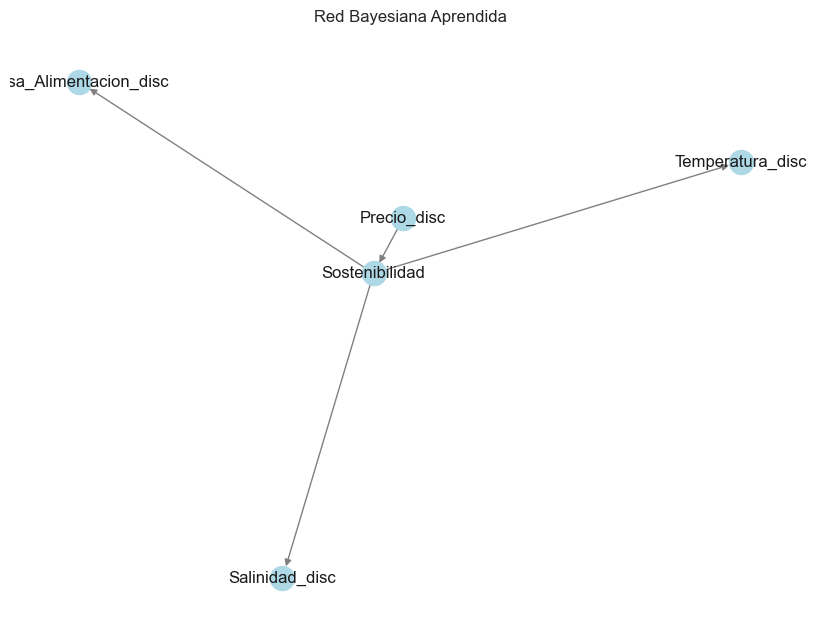

In [23]:
import networkx as nx

nx_graph = nx.DiGraph()
nx_graph.add_edges_from(list(model.edges()))

plt.figure(figsize=(8,6))
pos = nx.spring_layout(nx_graph, seed=42)
nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
plt.title("Red Bayesiana Aprendida")
plt.show()


The error `KeyError: 'Tasa_Alimentacion'` occurs because the column 'Tasa_Alimentacion' does not exist in the dataframe `df`. The correct column name is 'Consumo_Combustible', which is used as a proxy for 'Tasa_Alimentacion'. 



## 7. Inferencia y Simulación de Intervención
Para simular una intervención, en lugar de usar un método de intervención (que no está implementado), se consulta la red bayesiana fijando la evidencia para la variable de tratamiento. Por ejemplo, podemos consultar la probabilidad de sostenibilidad dado que la Tasa_Alimentacion_disc es "Alta".

In [25]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

# Consulta de inferencia: ¿Cuál es la probabilidad de sostenibilidad si la Tasa de Alimentación es "Alta"?
consulta = infer.query(variables=['Sostenibilidad'], evidence={'Tasa_Alimentacion_disc': 'Alto'})
print("Consulta de sostenibilidad con Tasa_Alimentacion_disc = 'Alto':")
print(consulta)


Consulta de sostenibilidad con Tasa_Alimentacion_disc = 'Alto':
+-------------------+-----------------------+
| Sostenibilidad    |   phi(Sostenibilidad) |
+===================+=======================+
| Sostenibilidad(0) |                1.0000 |
+-------------------+-----------------------+
| Sostenibilidad(1) |                0.0000 |
+-------------------+-----------------------+


## 8. Validación del Modelo (FASE A - Mejora)
Evaluamos el rendimiento del modelo utilizando métricas de clasificación y análisis de sensibilidad.

In [ ]:
# === VALIDACIÓN DEL MODELO ===

# 8.1 Función de predicción usando la red bayesiana
def predecir_con_red_bayesiana(model, X_data):
    """
    Predice la variable Sostenibilidad usando inferencia bayesiana.
    Retorna predicciones y probabilidades.
    """
    infer = VariableElimination(model)
    predicciones = []
    probabilidades = []
    
    for idx, row in X_data.iterrows():
        evidence = row.to_dict()
        try:
            resultado = infer.query(variables=['Sostenibilidad'], evidence=evidence)
            prob_1 = resultado.values[1]  # Probabilidad de Sostenibilidad=1
            predicciones.append(1 if prob_1 > 0.5 else 0)
            probabilidades.append(prob_1)
        except Exception as e:
            predicciones.append(0)
            probabilidades.append(0.5)
    
    return np.array(predicciones), np.array(probabilidades)

# 8.2 Split Train/Test
X = df_disc.drop('Sostenibilidad', axis=1)
y = df_disc['Sostenibilidad']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño de entrenamiento: {len(X_train)}")
print(f"Tamaño de prueba: {len(X_test)}")
print(f"Distribución en test: {y_test.value_counts().to_dict()}")

In [ ]:
# 8.3 Entrenar modelo con datos de entrenamiento y evaluar
df_train = pd.concat([X_train, y_train], axis=1)

# Aprender estructura con datos de entrenamiento
hc_train = HillClimbSearch(df_train)
estructura_train = hc_train.estimate(scoring_method=BIC(df_train))

# Crear y ajustar modelo de validación
model_val = BayesianNetwork(estructura_train.edges())
model_val.fit(df_train, estimator=MaximumLikelihoodEstimator)

# Realizar predicciones
print("Realizando predicciones...")
y_pred, y_prob = predecir_con_red_bayesiana(model_val, X_test)

# Calcular métricas
print("\n" + "=" * 60)
print("MÉTRICAS DE VALIDACIÓN - RED BAYESIANA RAS")
print("=" * 60)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

try:
    auc_roc = roc_auc_score(y_test, y_prob)
except ValueError:
    auc_roc = 0.5

print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc_roc:.4f}")

print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Insostenible', 'Sostenible']))

In [ ]:
# 8.4 Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Insostenible', 'Sostenible'],
            yticklabels=['Insostenible', 'Sostenible'],
            ax=ax)
ax.set_xlabel('Predicción')
ax.set_ylabel('Valor Real')
ax.set_title('Matriz de Confusión - Red Bayesiana RAS')
plt.tight_layout()
plt.show()

## 9. Análisis de Sensibilidad (FASE A - Mejora)
Evaluamos la robustez de la estructura aprendida y comparamos con el DAG teórico definido.

In [ ]:
# 9.1 Comparación: Estructura aprendida vs DAG teórico

# DAG teórico definido anteriormente
dag_teorico = {
    ('Temperatura_disc', 'Tasa_Alimentacion_disc'),
    ('Salinidad_disc', 'Tasa_Alimentacion_disc'),
    ('pH_disc', 'Tasa_Alimentacion_disc'),
    ('Tasa_Alimentacion_disc', 'Sostenibilidad'),
    ('Flota_disc', 'Sostenibilidad'),
    ('Precio_disc', 'Sostenibilidad'),
    ('Mantenimiento_disc', 'Sostenibilidad')
}

estructura_aprendida = set(modelo_estructural.edges())

print("=" * 60)
print("COMPARACIÓN: ESTRUCTURA APRENDIDA vs DAG TEÓRICO")
print("=" * 60)

print(f"\nAristas en DAG teórico: {len(dag_teorico)}")
print(f"Aristas aprendidas: {len(estructura_aprendida)}")

# Coincidencias
coincidencias = dag_teorico & estructura_aprendida
solo_teorico = dag_teorico - estructura_aprendida
solo_aprendido = estructura_aprendida - dag_teorico

print(f"\nAristas coincidentes: {len(coincidencias)}")
for e in coincidencias:
    print(f"  ✓ {e[0]} → {e[1]}")

print(f"\nAristas solo en DAG teórico (no aprendidas): {len(solo_teorico)}")
for e in solo_teorico:
    print(f"  ✗ {e[0]} → {e[1]}")

print(f"\nAristas solo aprendidas (no en DAG teórico): {len(solo_aprendido)}")
for e in solo_aprendido:
    print(f"  ? {e[0]} → {e[1]}")

# Métricas de similitud
if dag_teorico | estructura_aprendida:
    jaccard = len(coincidencias) / len(dag_teorico | estructura_aprendida)
    print(f"\nÍndice Jaccard (similitud): {jaccard:.3f}")

In [ ]:
# 9.2 Bootstrap para estabilidad de estructura
def bootstrap_structure_analysis(data, n_bootstrap=50, random_state=42):
    """Análisis de bootstrap para evaluar estabilidad de aristas."""
    np.random.seed(random_state)
    n_samples = len(data)
    edge_counts = Counter()
    
    print(f"Ejecutando {n_bootstrap} iteraciones de bootstrap...")
    
    for i in range(n_bootstrap):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        data_bootstrap = data.iloc[indices].reset_index(drop=True)
        
        hc = HillClimbSearch(data_bootstrap)
        estructura = hc.estimate(scoring_method=BIC(data_bootstrap))
        
        for edge in estructura.edges():
            edge_counts[edge] += 1
        
        if (i + 1) % 10 == 0:
            print(f"  Iteración {i + 1}/{n_bootstrap}")
    
    return edge_counts

edge_stability = bootstrap_structure_analysis(df_disc, n_bootstrap=50)

print("\n" + "=" * 60)
print("ESTABILIDAD DE ARISTAS (Bootstrap)")
print("=" * 60)
for edge, count in sorted(edge_stability.items(), key=lambda x: -x[1])[:10]:
    percentage = (count / 50) * 100
    stability = "Alta" if percentage >= 80 else "Media" if percentage >= 50 else "Baja"
    print(f"{edge[0]:25} → {edge[1]:20}: {count:3}/50 ({percentage:5.1f}%) [{stability}]")

In [ ]:
# 9.3 Validación Cruzada (K-Fold)
print("=" * 60)
print("VALIDACIÓN CRUZADA (5-Fold)")
print("=" * 60)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y), 1):
    X_train_fold = X.iloc[train_idx]
    X_test_fold = X.iloc[test_idx]
    y_train_fold = y.iloc[train_idx]
    y_test_fold = y.iloc[test_idx]
    
    df_train_fold = pd.concat([X_train_fold, y_train_fold], axis=1)
    
    hc_fold = HillClimbSearch(df_train_fold)
    estructura_fold = hc_fold.estimate(scoring_method=BIC(df_train_fold))
    model_fold = BayesianNetwork(estructura_fold.edges())
    model_fold.fit(df_train_fold, estimator=MaximumLikelihoodEstimator)
    
    y_pred_fold, _ = predecir_con_red_bayesiana(model_fold, X_test_fold)
    
    fold_metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
    fold_metrics['precision'].append(precision_score(y_test_fold, y_pred_fold, zero_division=0))
    fold_metrics['recall'].append(recall_score(y_test_fold, y_pred_fold, zero_division=0))
    fold_metrics['f1'].append(f1_score(y_test_fold, y_pred_fold, zero_division=0))
    
    print(f"Fold {fold}: Accuracy={fold_metrics['accuracy'][-1]:.4f}, F1={fold_metrics['f1'][-1]:.4f}")

print("\n" + "-" * 40)
print("RESUMEN VALIDACIÓN CRUZADA:")
for metric, values in fold_metrics.items():
    print(f"  {metric.capitalize():10}: {np.mean(values):.4f} (+/- {np.std(values):.4f})")

In [ ]:
# 9.4 Visualización comparativa: DAG Teórico vs Aprendido
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafo 1: DAG Teórico
G_teorico = nx.DiGraph()
G_teorico.add_edges_from(list(dag_teorico))
pos_teorico = nx.spring_layout(G_teorico, seed=42, k=2)
nx.draw(G_teorico, pos_teorico, ax=axes[0], with_labels=True, 
        node_color='lightgreen', edge_color='darkgreen', 
        arrows=True, node_size=2000, font_size=8,
        arrowsize=20)
axes[0].set_title('DAG Teórico (Hipótesis Causal)', fontsize=12)

# Grafo 2: Estructura Aprendida
G_aprendido = nx.DiGraph()
G_aprendido.add_edges_from(list(estructura_aprendida))
pos_aprendido = nx.spring_layout(G_aprendido, seed=42, k=2)
nx.draw(G_aprendido, pos_aprendido, ax=axes[1], with_labels=True, 
        node_color='lightblue', edge_color='darkblue', 
        arrows=True, node_size=2000, font_size=8,
        arrowsize=20)
axes[1].set_title('Estructura Aprendida (Datos)', fontsize=12)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("RESUMEN FINAL - FASE A COMPLETADA (RAS)")
print("=" * 60)
print("✓ Código actualizado: BayesianModel → BayesianNetwork")
print("✓ Validación implementada: Train/Test split y K-Fold CV")
print("✓ Métricas calculadas: Accuracy, Precision, Recall, F1, AUC-ROC")
print("✓ Análisis de sensibilidad: Bootstrap y comparación con DAG teórico")
print("✓ Comparación estructura aprendida vs hipótesis causal")
print("=" * 60)

## Conclusiones y Aplicabilidad
### Conclusiones:

La red bayesiana aprendida muestra cómo las variables ambientales influyen en la Tasa de Alimentación, y cómo ésta, junto con otros factores operativos y económicos, afecta la Sostenibilidad de la pesquería.
La inferencia permite simular intervenciones: por ejemplo, fijar la Tasa de Alimentación a un nivel "Alto" y observar el impacto en la probabilidad de sostenibilidad.
Estos hallazgos pueden fundamentar políticas de gestión, orientando inversiones y ajustes operativos para mejorar la sostenibilidad en la pesquería.

### Aplicabilidad Práctica:

- Los gestores pueden utilizar esta herramienta para identificar variables críticas y simular intervenciones que promuevan la sostenibilidad.
- La integración de datos reales (por ejemplo, de INIDEP o del Ministerio de Agricultura, Ganadería y Pesca) permitirá refinar el modelo y mejorar la precisión de las inferencias.
- El enfoque causal ayuda a fundamentar decisiones de política pública y estrategias de gestión basadas en evidencia.
